# Hyperparameter Integration and Model Selection with GPs 

This notebook code is mostly written on top of Alan's code in ccd and loo branch.

In [52]:
%matplotlib inline
import numpy as np
from pylab import *
from scipy import stats

In [2]:
import GPy

In [3]:
import matplotlib.pyplot as plt
import itertools
# import seaborn as sns

Test Model Selection by integrating out hyperparameters - A short demonstration
We will use grid integration, Laplace Approximation, MCMC and CCD integration 

In [4]:
SEED = 101
np.random.seed(SEED)

## Grid Integration
Function which does grid integration which can serve as our baseline ..

In [5]:
def gridIntegration(m, rangemin, rangemax, stepsize=0.1, optimize=True):
#     make sure that m is at mode - calculate marginal likelihood at gridpoints around mode, and then sum them up.  
    if optimize:
        m.optimize()
    modal_params = m.param_array[:].copy()
    optim_params = m.optimizer_array[None,:].copy()
    param_ranges = []
    for p in optim_params[0]:
        param_ranges.append(np.arange(rangemin, rangemax, stepsize))
    grids = itertools.product(*param_ranges)
    liksum = 0
    for el in grids:
        liksum += np.exp(-m._objective(el))
    return liksum*(stepsize**len(optim_params[0]))

## Laplace Approximation
Integration by laplace Approximation - fit a gaussian at modal value given by $ m_0*(\frac{1}{2\pi})|H^{-1}|$  where $m_0$ is the marginal likelihood at the mode of hyperparameters, and H is the hessian matrix at the mode.

In [6]:
def lapIntegration(m, optimize=True):
    if optimize:
        m.optimize()
    hessian = m.numerical_parameter_hessian()
    #   calculating hessian moves the model away from the mode and we need to get back to mode.
    m.optimize()
    lap_sum = np.exp(-m._objective(m2.param_array[:]))*1/np.sqrt(np.linalg.det(1/(2*np.pi)*hessian))
    return lap_sum

###  One dimensional data
We will perform ML inference first, followed by MAP inference and then finally integration of hyperparameters using different techniques available in GPy on a simple one dimensional regression task.

Select input data and make a simple GP Regression model

In [7]:
X = np.linspace(0,5,50)[:,None]
Y = np.sin(X)*3 + np.random.randn(*X.shape)*0.3 

Set kernel, likelihood and inference objects as RBF, Gaussian and Laplace respectively - standard GP Regression 

In [8]:
k = GPy.kern.RBF(1)
lik = GPy.likelihoods.Gaussian()
laplace = GPy.inference.latent_function_inference.Laplace()

### MLE Inference
Inference of hyperparameters in this model with Maximum Likelihood Estimation(MLE) as we have no priors for the hyperparameters. Actually GPy internally constrains the parameters to be positive, which is also a kind of prior, but just to keep things simple here, we do a simple optimisation.



In [9]:
m1 = GPy.core.GP(X.copy(), Y.copy(), k.copy(), lik.copy(), inference_method=laplace)

In [10]:
m1.optimize()

In [11]:
print(m1)
print(m1.param_array[:])
print(m1.optimizer_array[:])


Name : gp
Objective : 24.505804657
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |            value  |  constraints  |  priors
  rbf.variance             |    4.88239804642  |      +ve      |        
  rbf.lengthscale          |     1.5282147059  |      +ve      |        
  Gaussian_noise.variance  |  0.0907748252815  |      +ve      |        
[ 4.88239805  1.52821471  0.09077483]
[ 4.87479036  1.28369098 -2.35364256]


### Set up priors here ...

We will compare two priors: a gaussian and gamma prior. We can compare these priors when we do model comparison, in the second part of the notebook.

In [12]:
gaussian_prior1 = GPy.priors.Gaussian(1.5, 0.08)
gaussian_prior2 = GPy.priors.Gaussian(1.5, 1.0)

In [50]:
gamma_prior1 = GPy.priors.Gamma.from_EV(1.5, 0.2)
gamma_prior2 = GPy.priors.Gamma.from_EV(1.5, 0.7)
# very general prior- non informative ..
gamma_prior3 = GPy.priors.Gamma.from_EV(1.0, 2.)

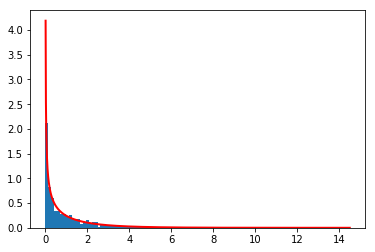

In [51]:
# gaussian_prior_2.plot()
gamma_prior3.plot()

In [15]:
m2 = GPy.core.GP(X.copy(), Y.copy(), k.copy(), lik.copy(), inference_method=laplace)

In [16]:
print(m1)


Name : gp
Objective : 24.505804657
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |            value  |  constraints  |  priors
  rbf.variance             |    4.88239804642  |      +ve      |        
  rbf.lengthscale          |     1.5282147059  |      +ve      |        
  Gaussian_noise.variance  |  0.0907748252815  |      +ve      |        


### MAP Inference
Inference of hyperparameters through MAP(Maximise aposteriori) for these models. Here we will set up a prior on the lengthscale and noise variance. The model is sensitive to the choice of priors. We will pick two priors: one with a very small width, so it is almost equivalent to ML inference, and the second prior has a wider width.
$$ p(\theta|D) \propto p(D| \theta)p(\theta) $$
$$ \log p(\theta|D) =  \log p(D| \theta) + \log p(\theta) - Constant$$
$$ \hat{\theta}, \hat{\phi} = \mathop{\mathrm{argmax}}_{\theta} p(\theta|D), \mathop{\mathrm{argmax}}_{\phi} p(\phi|D)$$
where $\theta$ represents parameters of kernel function like lengthscale, and $\phi$ represents parameters of likelihood function like variance.
### @TODO: write equations for this.


In [17]:
# m2.unconstrain()
m2.kern.lengthscale.unconstrain()
m2['.*Gaussian_noise'].unconstrain()
m2['.*variance'].unconstrain()
m2.kern.lengthscale.set_prior(gaussian_prior1)

In [18]:
print(m2[''])
m2.checkgrad()

  index  |             gp.rbf.variance  |  constraints  |     priors   
  [0]    |                  1.00000000  |               |              
  -----  |          gp.rbf.lengthscale  |  -----------  |  ------------
  [0]    |                  1.00000000  |               |  N(1.5, 0.08)
  -----  |  gp.Gaussian_noise.variance  |  -----------  |  ------------
  [0]    |                  1.00000000  |               |              


True

In [19]:
m2.optimize()

 /u/26/dhakaa1/unix/anaconda2/envs/gpy27-devel/lib/python2.7/site-packages/GPy/inference/latent_function_inference/laplace.py:333: RuntimeWarning:invalid value encountered in sqrt


In [20]:
print(m2)
print(m2.log_likelihood())
# print(m2._objective())


Name : gp
Objective : 31.5358347358
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |           value  |  constraints  |     priors   
  rbf.variance             |   1.24558325287  |               |              
  rbf.lengthscale          |   1.51941182093  |               |  N(1.5, 0.08)
  Gaussian_noise.variance  |  0.188361757901  |               |              
-33.1131858788


In [21]:
modal_point = m2.param_array[:].copy()

In [22]:
m2.log_likelihood()
print(m2)


Name : gp
Objective : 31.5358347358
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |           value  |  constraints  |     priors   
  rbf.variance             |   1.24558325287  |               |              
  rbf.lengthscale          |   1.51941182093  |               |  N(1.5, 0.08)
  Gaussian_noise.variance  |  0.188361757901  |               |              


### Hyperparameter integration 
To take into account the full uncertainity of the hyperparameters, we need to integrate over them. We will cover this with MCMC sampling, grid integration, laplace approximation and CCD. The marginal posterior of the latent values can be  written as:

$$p(\textbf{f}|D) = \int p(\textbf{f},\theta|D)d\theta = \frac{1}{Z}\int p(y|\textbf{f})p(\textbf{f}|X, \theta)p(\theta)d\theta $$
where $f$ is the vector of latent values, Z is the normalization constant given as $$Z = \int \int p(y|\textbf{f})p(\textbf{f}|X, \theta)p(\theta)d\theta df$$, and $D=(X,Y)$ is the set of training input and training outputs. If we change the order of integration and integrate out  $ \textbf{f}$ first, then we get an estimate of marginal likelhood, which we use for standard GP regression.

Integration over hyperparameter space is intractable, so we can use an approximation through finite sum:
 $$  p(f|D) \approx \sum_{i=1}^{M} p(\textbf{f}|D, \gamma_{i}) p(\gamma_{i}|D) \delta_{i}  $$
 where $\gamma_{i}$ represents log transformation of $\theta_{i}$ and $\delta_{i}$ is the area(voulme) weight contributed by the evaluation point in transformed hyperparameter space $\gamma_{i}$. 


### Integration with HMC

In [23]:
m_hmc = GPy.core.GP(X, Y,  k.copy(), lik.copy(), inference_method=laplace)

 /u/26/dhakaa1/unix/anaconda2/envs/gpy27-devel/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


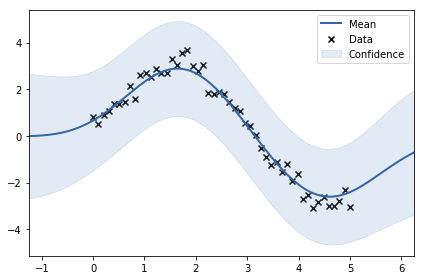

In [24]:
m_hmc.unconstrain()
m_hmc.kern.lengthscale.set_prior(gamma_prior3)
m_hmc.kern.variance.set_prior(gamma_prior3)
m_hmc.likelihood.variance.set_prior(gamma_prior3)
_=m_hmc.plot()

Do the inference with MCMC and plot the samples 

In [25]:
hmc = GPy.inference.mcmc.HMC(m_hmc, stepsize=5e-2)
# Burnin
s = hmc.sample(num_samples=1000)
s = hmc.sample(num_samples=2000)

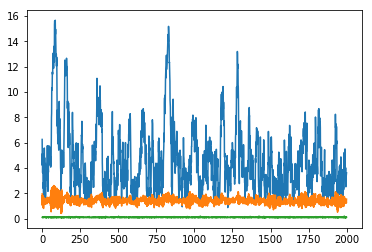

In [26]:
plot(s)

Now plot the marginal posterior distributions of model parameters:

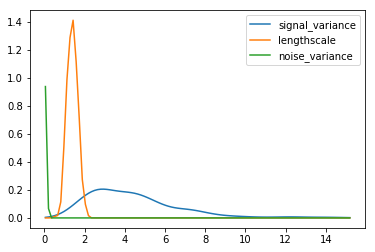

In [31]:
labels = ['signal_variance' , 'lengthscale', 'noise_variance']
# Remove burnin
samples = s[500:]
# thinning
samples = samples[::2]
xmin = samples.min()
xmax = samples.max()
xs = np.linspace(xmin, xmax, 100)
for i in xrange(samples.shape[1]):
    kernel = stats.gaussian_kde(samples[:,i])
    plot(xs,kernel(xs),label=labels[i])
_ = legend()


Plot the samples of lengthscale, noise variance and sigmal variance against each other two at a time.

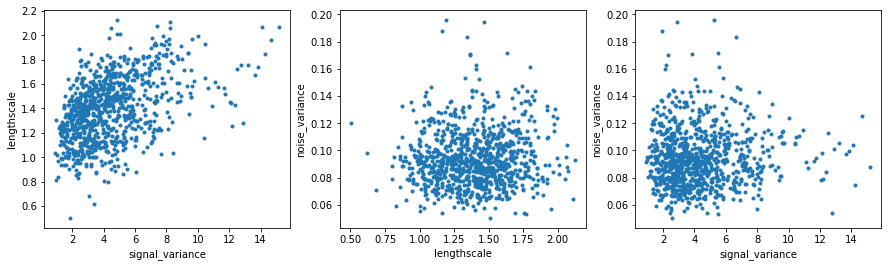

In [28]:
fig = figure(figsize=(15,4))
ax = fig.add_subplot(131)
_=ax.plot(samples[:,0],samples[:,1],'.')
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[1])
ax = fig.add_subplot(132)
_=ax.plot(samples[:,1],samples[:,2],'.')
ax.set_xlabel(labels[1]); ax.set_ylabel(labels[2])
ax = fig.add_subplot(133)
_=ax.plot(samples[:,0],samples[:,2],'.')
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[2])


Name : gp
Objective : 94.2381011632
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |          value  |  constraints  |      priors    
  rbf.variance             |  2.67635935686  |      +ve      |  Ga(0.14, 0.14)
  rbf.lengthscale          |  2.72130466981  |      +ve      |  Ga(0.14, 0.14)
  Gaussian_noise.variance  |  2.58229959999  |      +ve      |  Ga(0.14, 0.14)


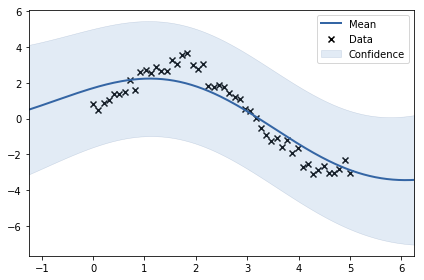

In [49]:
# set the model parameters at the posterior mean
m_hmc.kern.variance[:] = samples[0].mean()
m_hmc.kern.lengthscale[:] = samples[1].mean()
m_hmc.likelihood.variance[:] = samples[2].mean()
print(m_hmc)
m_hmc.plot()

### Grid Integration
@TODO: Write something about grid integration 

Small note on Implementation details:
Be careful with the param_array and optimizer_array as they are two different entities. Optimizer_array contains only the unfixed and tranformed values, on which the actual optimizer works on, while the param_array contains all the parameter values associated with the model, the end user-(person who is doing modelling and setting up priors) sees. For example, if we put a constraint that a particular parameter should be positive, then GPy internally does a LogExp transformation to map it to optimizer space, and once optimisation is done , transforms it back to the param space with ExpLog transformation. 

In [30]:
grid_sum = gridIntegration(m2, rangemin=0.0001, rangemax=20, stepsize=0.2)

### Laplace Integration
@TODO: Write about integration by laplace approximation.

In [32]:
lap_sum = lapIntegration(m2)

In [33]:
print grid_sum, lap_sum

1.61368997476e-13 1.21808333832e-27


### CCD Integration
@TODO: Write about CCD Integration

In [46]:
m2.optimize()

In [47]:
ccdpos,ccddensity,scalings,z = m2.CCD()

Hessian is not positive definite, ensure parameters are at their MAP solution by optimizing, if that doesn't work try modifying the step length parameter in finite differences


TypeError: 'NoneType' object is not iterable

In [ ]:
# ccdpos,ccdres,scalings,z = m2.CCD()

## Model Selection
Compare different priors with LOO score or Hyperparameter integration.

## References
1. Jarno Vanhatalo, Ville Pietiläinen, and Aki Vehtari. 2010. Approximate inference
for disease mapping with sparse Gaussian processes. Statistics in Medicine,
volume 29, number 15, pages 1580-1607.